# 🎵 Word Graph Analysis for Song Lyrics

**Description:**  
In this notebook, we’ll build and explore a co‐occurrence network of words (tokens) extracted from a collection of song lyrics. By treating each unique token as a node and drawing edges when two words appear within a sliding window in the same lyric, we can reveal interesting patterns—clusters of related terms, central “hub” words, and thematic communities across songs.

**What You’ll Find Here:**  
1. **Data Loading & Cleaning**  
   - Read in a compiled dataset of lyrics (original and translated).  
   - Filter out non‐English songs, remove stopwords, and handle punctuation or plurals to standardize tokens.  

2. **Tokenization & Preprocessing**  
   - Split each lyric into a sequence of tokens.  
   - Normalize (lowercase, strip punctuation) and optionally stem/lemmatize.  

3. **Graph Construction**  
   - Define a sliding‐window approach to connect tokens that co‐occur within a specified range.  
   - Build a NetworkX graph where edge weights count how often two tokens appear together.

4. **Filtering & Analysis**  
   - Apply thresholds (e.g., minimum edge weight, k‐core) to focus on significant connections.  
   - Compute basic network statistics (average degree, modularity) to gauge overall structure.

5. **Export for Visualization**  
   - Save the pruned graph to formats compatible with Gephi (e.g., GEXF).  
   - Provide guidance on how to import and style the graph in Gephi for clearer insights.

In [1]:
# ──────────────────────────────────────────────────────────────
# 0. Imports & setup
# ──────────────────────────────────────────────────────────────
import re, string, pickle, pathlib
from collections import Counter, defaultdict
from itertools import islice
import pandas as pd
import networkx as nx
import spacy
from tqdm.auto import tqdm   # progress bars

# Load spaCy with everything off except tagger+lemmatizer
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [2]:
DATA_DIR   = pathlib.Path("../data/processed/")
IN_FILE    = DATA_DIR / "hot100_translated.xlsx"
OUT_DF     = DATA_DIR / "billboard_2024_clean.pkl"
WINDOW_SIZES = [3, 5, 10]    # tweak as you like

In [3]:
df = pd.read_excel(IN_FILE)
print(f"Loaded {len(df):,} songs")

Loaded 758 songs


In [4]:
full_df = pd.read_excel(DATA_DIR / "dataset.xlsx")
print(f"Loaded {len(full_df):,} songs")

Loaded 5,200 songs


## Song Frequency Count

In [5]:
# ── Count how many times each song appears ──
freq = (
    full_df.groupby("song_id")
        .size()           
        .rename("dup_count")
        .reset_index()
)

freq

,song_id,dup_count
0,020299__that_mexican_ot,3
1,16_carriages__beyonce,6
2,23__chayce_beckham,20
3,25__rod_wave,10
4,28__zach_bryan,20
...,...,...
756,your_place__ashley_cooke,4
757,youre_a_mean_one_mr_grinch__thurl_ravenscroft,1
758,youre_gonna_go_far__noah_kahan,1
759,youre_losing_me_from_the_vault__taylor_swift,3


In [6]:
# ── Attach the counts to the unique table ──
df = df.merge(freq, on="song_id", how="left")
df["dup_count"].fillna(1, inplace=True)   # safety for any IDs missing in df
df["dup_count"] = df["dup_count"].astype(int)

df["dup_count"].describe()

C:\Users\royic\AppData\Local\Temp\ipykernel_46348\3302603126.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dup_count"].fillna(1, inplace=True)   # safety for any IDs missing in df


count    758.000000
mean       6.840369
std        8.377936
min        1.000000
25%        1.000000
50%        3.000000
75%       10.000000
max       52.000000
Name: dup_count, dtype: float64

## Preprocessing Tokens

In [7]:
import contractions          # %pip install contractions

def expand_contractions(text: str) -> str:
    return contractions.fix(text, slang=True)   # covers 'cause → because, ain't → am not …

In [8]:
CUSTOM_STOP = {
    # discourse fillers / helper verbs
    "like","yeah","uh","oh","got","wanna","get","know","tell","come",
    "go","want","look","cause","not","no", "gon", "let"
}
ALLOWED_POS = {"NOUN","ADJ","VERB","ADV"}         # keep only content words

PLURAL_MAP = {"niggas": "nigga", "bitches": "bitch", "hoes": "hoe"}

PROFANE = {"nigga", "bitch", "hoe", "shit", "fuck"}   # expand as needed
PROF_PLACEHOLDER = "<profane>"

PUNCT_TABLE = str.maketrans("", "", string.punctuation)

In [9]:
def clean_text(text: str) -> str:
    """Lower-case + expand contractions, THEN strip punctuation."""
    if not isinstance(text, str):
        return ""          
    text = expand_contractions(text.lower().replace("’", "'"))
    text = text.translate(PUNCT_TABLE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [10]:
def tokens_for_song(doc):
    """spaCy Doc → list of clean lemmas ready for graph building."""
    tokens = []
    for tok in doc:
        if (
            tok.pos_ in ALLOWED_POS
            and tok.is_alpha
            and not tok.is_stop
        ):
            lemma = tok.lemma_.lower()
            lemma = PLURAL_MAP.get(lemma, lemma)           # collapse slang plurals
            if lemma in CUSTOM_STOP or len(lemma) == 1:
                continue
            tokens.append(lemma)
    return tokens

In [11]:
tqdm.pandas(desc="spaCy")

df["lyrics_clean"] = (
    df["lyrics_en"]
      .map(clean_text)
      .progress_apply(lambda t: tokens_for_song(nlp(t)))
)

spaCy:   0%|          | 0/758 [00:00<?, ?it/s]

In [12]:
token_len_df = df["lyrics_clean"].str.len()
token_len_df.describe()

count    758.000000
mean     123.156992
std       64.229344
min        0.000000
25%       82.000000
50%      110.500000
75%      148.000000
max      580.000000
Name: lyrics_clean, dtype: float64

## Build Co‐Occurrence Graph

In [32]:
def build_weighted_graph(token_lists, weights, window=5):
    """
    token_lists : iterable[list[str]]
    weights     : iterable[int]      (same length; usually dup_count)
    window      : size of sliding window for co-occurrence
    -------------------------------------------------------------
    returns     : NetworkX Graph with edge attribute 'weight'
    """
    G = nx.Graph()
    for tokens, w in zip(token_lists, weights):
        if not tokens or w == 0:
            continue
        for i, tok in enumerate(tokens):
            for partner in islice(tokens, i+1, i+window):
                if tok == partner:
                    continue
                # accumulate weight
                if G.has_edge(tok, partner):
                    G[tok][partner]["weight"] += w
                else:
                    G.add_edge(tok, partner, weight=w)
    return G

In [72]:
print("Building popularity-weighted graph …")
G_exposure = build_weighted_graph(
    df["lyrics_clean"],
    df["dup_count"],
    window=5
)

print(f"Done: {G_exposure.number_of_nodes():,} nodes | "
      f"{G_exposure.number_of_edges():,} edges")

Building popularity-weighted graph …
Done: 10,588 nodes | 195,729 edges


In [73]:
# What words dominate once popularity is factored in?
top_deg = sorted(G_exposure.degree, key=lambda x: x[1], reverse=True)[:20]
print("\nTop 20 words by degree:")
for w, d in top_deg:
    print(f"{w:<12} {d:>6}")


Top 20 words by degree:
bitch          2144
nigga          2060
love           1837
shit           1796
fuck           1796
time           1561
baby           1501
think          1397
feel           1350
way            1331
good           1326
need           1312
say            1204
life           1191
right          1175
leave          1162
girl           1103
man            1044
night          1008
thing          1004


In [75]:
# Export

OUT_GEXF  = DATA_DIR / f"word_graph_exposure_clean.gexf"
G_gephi = nx.relabel_nodes(G_exposure, str)
nx.write_gexf(G_gephi, OUT_GEXF)

print(f"✅  Exported → {OUT_GEXF.resolve()}")


✅  Exported → C:\Users\royic\OneDrive\Desktop\לימודים\שנה ג\סמסטר ב\טקסט כנתונים\billboard-100-lyrics-analysis\data\processed\word_graph_exposure_clean.gexf


In [76]:
df["dup_count"].describe()

count    758.000000
mean       6.840369
std        8.377936
min        1.000000
25%        1.000000
50%        3.000000
75%       10.000000
max       52.000000
Name: dup_count, dtype: float64

count     195729.00
min            1.00
max         2668.00
mean          11.51
median         4.00
std           29.41
q25            1.00
q75           12.00
dtype: float64


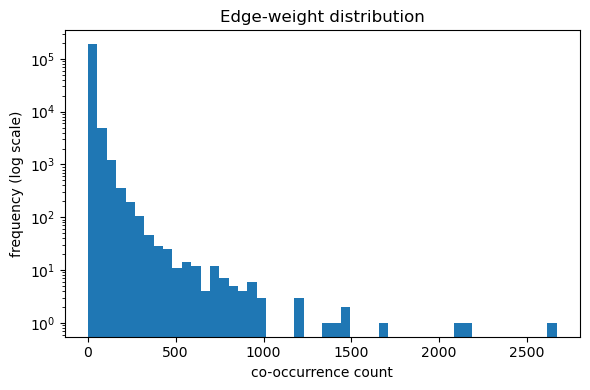

In [83]:
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt

# 1) Pull all edge-weight values into a NumPy array
w = np.array([d["weight"] for _, _, d in G_exposure.edges(data=True)])

# 2) Text summary
edge_stats = pd.Series({
    "count"   : len(w),
    "min"     : w.min(),
    "max"     : w.max(),
    "mean"    : w.mean(),
    "median"  : stats.median(w),
    "std"     : w.std(ddof=1),
    "q25"     : np.percentile(w, 25),
    "q75"     : np.percentile(w, 75),
})
print(edge_stats.round(2))

# 3) (Optional) Histogram to eyeball the distribution
plt.figure(figsize=(6,4))
plt.hist(w, bins=50)
plt.yscale("log")           # reveals the long-tail shape nicely
plt.title("Edge-weight distribution")
plt.xlabel("co-occurrence count")
plt.ylabel("frequency (log scale)")
plt.tight_layout()
plt.show()


## Wordcloud

In [18]:
# -----------------------------------------------------------------------------
# 1) Build a flat list of all tokens, weighted by each song’s dup_count.
# -----------------------------------------------------------------------------
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_tokens = []
for tokens_list, weight in zip(df["lyrics_clean"], df["dup_count"]):
    if not isinstance(tokens_list, list) or weight == 0:
        continue
    
    # `tokens_list` is already a list of cleaned tokens (strings)
    # Repeat each token by the song's weight (dup_count)
    for tok in tokens_list:
        all_tokens.extend([tok] * weight)

In [19]:
# -----------------------------------------------------------------------------
# 2) Count frequencies
# -----------------------------------------------------------------------------
freq_dict = Counter(all_tokens)

freq_dict

Counter({'love': 10211,
         'baby': 7836,
         'bitch': 6079,
         'fuck': 5530,
         'think': 5425,
         'nigga': 5295,
         'good': 4681,
         'time': 4530,
         'way': 4332,
         'night': 4199,
         'girl': 4080,
         'say': 3994,
         'right': 3970,
         'shit': 3745,
         'need': 3402,
         'leave': 3320,
         'feel': 3275,
         'life': 3223,
         'thing': 3065,
         'heart': 2922,
         'lose': 2909,
         'day': 2527,
         'bad': 2307,
         'stop': 2303,
         'hit': 2286,
         'man': 2255,
         'boy': 2251,
         'well': 2210,
         'long': 2196,
         'try': 2192,
         'world': 2146,
         'break': 2093,
         'find': 2015,
         'dance': 1973,
         'away': 1912,
         'mind': 1896,
         'lie': 1891,
         'turn': 1890,
         'talk': 1808,
         'friend': 1800,
         'wait': 1775,
         'eye': 1745,
         'little': 1709,
     

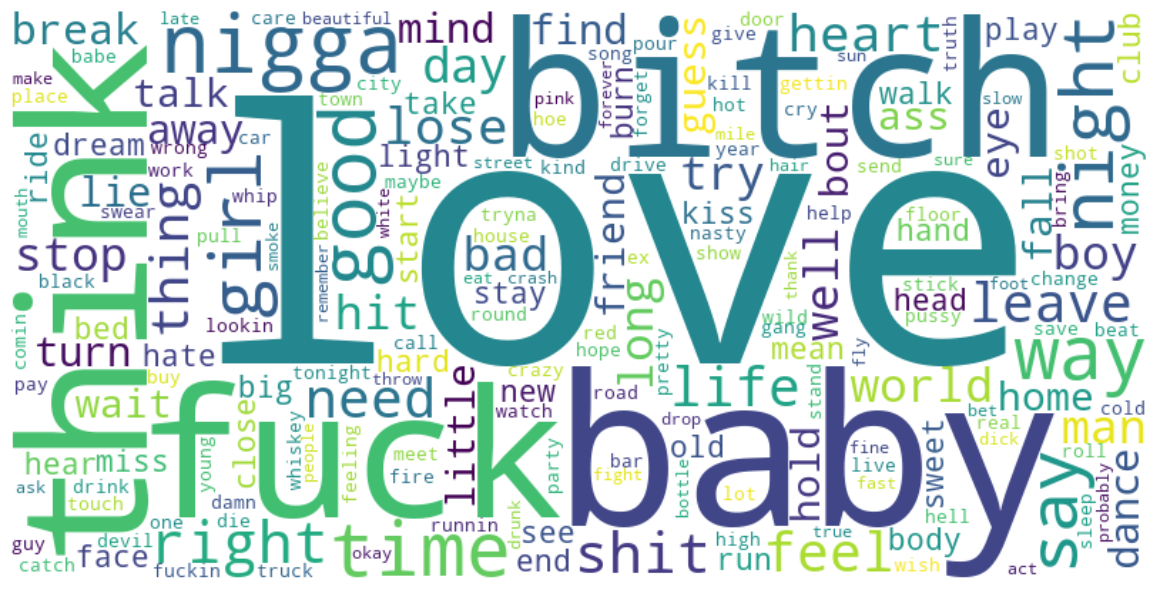

In [20]:
# -----------------------------------------------------------------------------
# 3) Generate & display the word cloud
# -----------------------------------------------------------------------------
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
).generate_from_frequencies(freq_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

In [21]:
# Save directly to disk as PNG (or JPG, etc.)
output_path = "../wordcloud.png"
wc.to_file(output_path)